<a href="https://colab.research.google.com/github/mpedraza98/MLTSA22_MPedraza/blob/main/HW9/MP_HW9_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [ ]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras import backend as K

In [ ]:
import seaborn as sns

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
from tensorflow import keras
from keras import optimizers
from keras.callbacks import EarlyStopping

In [ ]:
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
!ls

gdrive	sample_data


In [ ]:
cd /content/gdrive/MyDrive/MLTSA22

/content/gdrive/MyDrive/MLTSA22


In [ ]:
flux_ts = pd.read_csv('data.csv', header = None)

In [ ]:
flux_ts.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.711029,7.929379e-01,-0.030939,-0.687774,-2.476340e-01,7.125589e-01,0.874526,1.846553e-01,-0.267378,-1.863665e-01,...,-3.492236e-11,-5.634907e-13,3.316947e-15,1.999942e-16,2.004991e-18,1.374632e-21,-9.564481e-23,-5.843134e-25,-7.887651e-28,3.663458e-30
1,-0.576466,1.064696e-61,0.007776,-0.011913,5.443351e-40,9.182100e-09,-0.308950,1.847434e-152,-0.000893,-6.692231e-09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,-0.704222,2.080825e-01,0.754056,-0.005472,6.811945e-01,5.188407e-01,-0.390501,-1.598396e-01,-0.388993,-5.805594e-01,...,1.413223e-12,8.491510e-17,6.414484e-23,-8.616802e-27,-1.616677e-32,-3.888634e-39,-4.606079e-47,4.343212e-54,3.312239e-62,3.170011e-71
3,-0.070055,-3.952116e-02,0.287361,-0.230490,-2.880674e-02,7.774933e-02,-0.808792,7.953404e-04,0.109165,-2.645501e-03,...,-1.629197e-115,1.570500e-155,-1.569295e-201,1.625452e-253,-1.745204e-311,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.365410,-2.116572e-02,0.586783,-0.411286,1.557213e-03,1.448403e-01,-0.818455,3.059596e-04,0.602409,-1.526490e-02,...,4.646419e-126,-1.382347e-169,1.144647e-219,-2.685664e-276,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


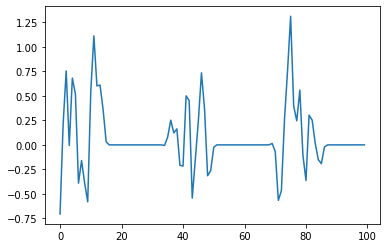

In [ ]:
pl.plot(flux_ts.loc[2]);

**Fig 1.** Time series plot for a random object in the dataset. This plot only meant to verify the content of our data

In [ ]:
# Splitting the data into training and test sets
X_tr,  X_te = train_test_split(flux_ts, test_size=0.25)

In [ ]:
X_tr.shape

(35316, 100)

In [ ]:
# We will be using a callback to stop the iterations early if necessary and adam optimizer

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
callback = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [ ]:
in_dim = X_tr.shape[1]
out_dim = X_tr.shape[1]

We first tried using RELU as the activation function, however, since the flux values can fluctuate towards the negative, RELU fails to correctly predict this behavior. Hence, we will use tanh or leaky relu which can work with negative values as well

In [ ]:
# The architecture used was 100 (input size) -> 256 -> 128 -> 64 -> 32 -> 64 -> 128 -> 256 -> (output size)
model = Sequential()
## encoder
# input layer and the output size
model.add(Dense(256, activation='tanh', input_dim = in_dim))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh', name='bottleneck_layer'))
## deencoder
#decompression layer, same size as in the encoder
model.add(Dense(64, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(256, activation='tanh'))
#output layer, same size as input
model.add(Dense(out_dim, activation='tanh'))

In [ ]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 256)               25856     
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 bottleneck_layer (Dense)    (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 64)                2112      
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 dense_27 (Dense)            (None, 256)              

In [ ]:
model.compile(loss="mean_squared_error", optimizer=opt)

In [ ]:
history = model.fit(X_tr, X_tr, validation_data=(X_te, X_te),
                               epochs=40, batch_size=100, verbose=1,
                               callbacks=[callback])

Epoch 1/40
354/354 [==============================] - 4s 8ms/step - loss: 0.1847 - val_loss: 0.1572
Epoch 2/40
354/354 [==============================] - 3s 7ms/step - loss: 0.1482 - val_loss: 0.1423
Epoch 3/40
354/354 [==============================] - 3s 8ms/step - loss: 0.1381 - val_loss: 0.1360
Epoch 4/40
354/354 [==============================] - 3s 7ms/step - loss: 0.1335 - val_loss: 0.1330
Epoch 5/40
354/354 [==============================] - 3s 7ms/step - loss: 0.1311 - val_loss: 0.1313
Epoch 6/40
354/354 [==============================] - 3s 8ms/step - loss: 0.1295 - val_loss: 0.1300
Epoch 7/40
354/354 [==============================] - 3s 8ms/step - loss: 0.1283 - val_loss: 0.1291
Epoch 8/40
354/354 [==============================] - 3s 8ms/step - loss: 0.1274 - val_loss: 0.1284
Epoch 9/40
354/354 [==============================] - 3s 8ms/step - loss: 0.1267 - val_loss: 0.1278
Epoch 10/40
354/354 [==============================] - 3s 8ms/step - loss: 0.1261 - val_loss: 0.1273

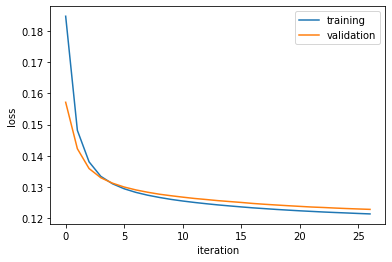

In [ ]:
fig = pl.figure(figsize = (10,6))
pl.plot(np.array(history.history['loss']), label="training")
pl.plot(np.array(history.history['val_loss']), label="validation")
pl.ylabel('loss')
pl.xlabel('iteration')
pl.legend()

**Fig 2.** Learning curve for our autoencoder model. Since the validation curve is on top of the training curve this might indicate overfitting. It is worth noticing that the gap between curves is small, therefore we should explore further the overfitting hypotesis. 

In case that's true, we could possibly explore and adjust to the parameters of the callback function so that the model doesn't train for too long. 

In [ ]:
prediction = model.predict(X_te)

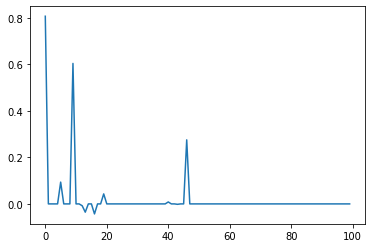

In [ ]:
# Original Timeseries
pl.plot(X_te.iloc[20])

**Fig 3.1** Original timeseries plot for a random object from the test dataset.

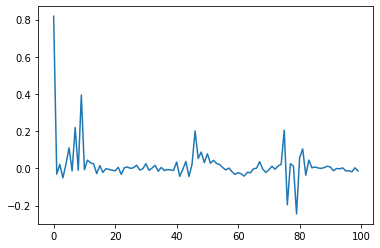

In [ ]:
# Prediction
pl.plot(prediction[20])

**Fig 3.2** Autoencoder prediction for the same timeseries as in Fig 3.1. As we can see, it reproduces moderately well the behaviour of the original data, however at the final part it adds some peaks that are not present initially, this might be understood since almost all the time series consist of three spatially separated chuncks of data, and for the present case, the original timeseries had no information at the end of it

<font color="red"> FBB ok</font>

We will extract features from the bottleneck layer

In [ ]:
# Inspired by this stackoverflow thread 
# https://stackoverflow.com/questions/50226919/extracting-features-from-the-bottleneck-layer-in-keras-autoencoder
# bottleneck model
bottleneck_output = model.get_layer('bottleneck_layer').output
model_bottleneck = Model(inputs = model.input, outputs = bottleneck_output)

In [ ]:
# Predict the bottleneck model for the whole dataset
bottleneck_predictions = model_bottleneck.predict(flux_ts)

In [ ]:
bottleneck_predictions.shape

(47088, 32)

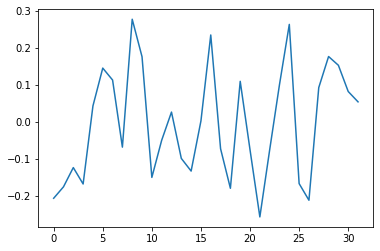

In [ ]:
pl.plot(bottleneck_predictions[0])

**Fig 4** Visualization of the output from the bottleneck layer. It looks like it captures the possibly periodic behavior from the timeseries.

<font color="red"> FBB yeah this is not usually very insightful</font>

In [ ]:
# Reshape the array to put the timeseries as columns for the classification
bottleneck_predictions = bottleneck_predictions.reshape(7848, bottleneck_predictions.shape[1] * 6)

In [ ]:
allfeatures = pd.read_csv('allfeatures.csv')
target = pd.read_csv('labels.csv')

In [ ]:
target.drop('Unnamed: 0', axis = 1, inplace = True)
target.set_index('object_id', inplace = True)

In [ ]:
target.head()

,target
object_id,
615,92
713,88
730,42
745,90
1124,90


In [ ]:
allfeatures.set_index('object_id', inplace = True)

In [ ]:
allfeatures.head()

,0_mean,0_std,0_m2,0_m3,0_max,0_min,0_median,1_mean,1_std,1_m2,...,4_min,4_median,5_mean,5_std,5_m2,5_m3,5_max,5_min,5_median,decl
object_id,,,,,,,,,,,,,,,,,,,,,
615,-3.254554,83.944735,6934.865833,72665.792850,125.182808,-116.913223,-0.080537,-385.699911,601.787302,355904.026224,...,-422.184509,-0.163078,-47.449847,294.779522,85370.493377,3.041829e+06,378.188141,-422.815094,-0.129163,-61.943836
713,-2.720398,7.113509,49.879128,89.634243,14.509829,-14.735178,-0.052914,-1.019804,5.712334,32.048070,...,-12.286801,0.016870,-1.794175,7.094073,49.427194,7.377121e+01,14.770886,-14.211164,-0.094281,-27.784405
730,-0.048080,1.828872,3.298318,2.093148,5.942166,-3.459960,0.039463,0.141057,1.807229,3.203266,...,-5.836310,-0.308522,4.539396,13.332758,174.276892,3.751336e+03,47.310059,-19.159811,-0.149763,-6.579593
745,1.797523,4.374445,18.869993,162.368381,18.014029,-3.874349,-0.169349,5.717394,25.964659,662.124902,...,-15.494463,-0.358773,10.746138,26.060130,666.782529,5.309464e+04,141.513290,-10.249387,-0.306851,-45.586655
1124,0.660948,2.360084,5.481586,-4.160853,5.330927,-6.804703,-0.033864,4.634637,8.107525,64.598653,...,-16.543753,-0.303771,6.896742,21.434627,451.382820,3.414365e+04,109.157585,-10.860540,-0.229697,-63.823658


In [ ]:
allfeatures.shape, bottleneck_predictions.shape

((7848, 43), (7848, 192))

In [ ]:
# Merge the output from the bottleneck layer with the allfeatures dataset from HW7
# In that notebook I included a function which saved the dataset to go google drive 
# together with the target variables for building the clasiffier later on

In [ ]:
final_features = np.concatenate([allfeatures.values, bottleneck_predictions], axis = 1)

In [ ]:
label_dist = target.groupby(['target']).agg({'target':'count'})

In [ ]:
label_dist.target.values

array([ 151,  495,  924, 1193,  183,   30,  484,  102,  981,  208,  370,
       2313,  239,  175])

No handles with labels found to put in legend.


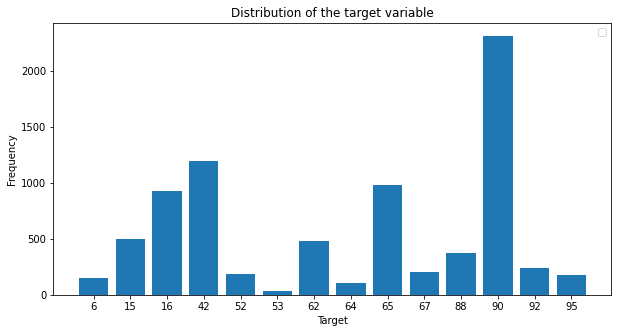

In [ ]:
pl.figure(figsize=(10,5))
pl.bar(label_dist.index.astype(str), label_dist.target.values);
pl.title("Distribution of the target variable");
pl.xlabel("Target")
pl.ylabel("Frequency")
pl.legend();

**Figure 5.** *'Target'* variable Histogram. We can see that the data is imbalanced, therefore, gradient booster might be a better choice than random forest. We will try first the random forest in the interest of time, and later explore the possibility of a gradient booster algorithm.

<font color="red"> FBB good point</font>

In [ ]:
rf = RandomForestClassifier(random_state = 0)
print('Parameters currently in use:\n')
for i in rf.get_params().items():
  print(i)

Parameters currently in use:

('bootstrap', True)
('ccp_alpha', 0.0)
('class_weight', None)
('criterion', 'gini')
('max_depth', None)
('max_features', 'auto')
('max_leaf_nodes', None)
('max_samples', None)
('min_impurity_decrease', 0.0)
('min_samples_leaf', 1)
('min_samples_split', 2)
('min_weight_fraction_leaf', 0.0)
('n_estimators', 100)
('n_jobs', None)
('oob_score', False)
('random_state', 0)
('verbose', 0)
('warm_start', False)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_features, target.target.values, test_size=0.2)

In [ ]:
rf = RandomForestClassifier(max_depth=4, random_state=123)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=123)

In [ ]:
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.4745141764893278, 0.47388535031847134)

<font color="red"> FBB I need a bit more comments here</font>

In [ ]:
# I used the confusion matrix plot showed in 
# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python

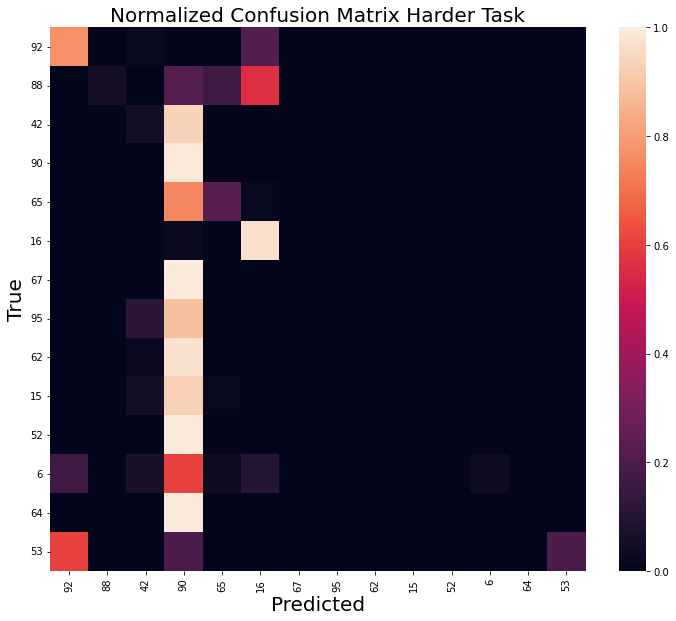

In [ ]:
# Plot confusion matrix in a beautiful manner
cm = confusion_matrix(y_test, rf.predict(X_test), labels = target.target.unique(), normalize='true')
fig = pl.figure(figsize=(12, 10))
ax= pl.subplot()
sns.heatmap(cm, annot=False, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
pl.xticks(rotation=90)
ax.xaxis.set_ticklabels(target.target.unique(), fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(target.target.unique(), fontsize = 10)
pl.yticks(rotation=0)

pl.title('Normalized Confusion Matrix Harder Task', fontsize=20)

pl.show()

**Figure 6.** The normalized confusion matrix allows us to visualize the class imbalance still carried by the model and the poor performance of the random forest used. The features with greater frequency are predicted often by our model. We will need to look deeper for correlations and hyperparameters that we can change to deal with the lack of accuracy and imporve the hyperparameters choice.

Furthermore, it will be better to consider the gradient booster algorithm which handles more appropiately the class imbalance problem.

<font color="red"> FBB ok</font>

In [ ]:
gbt = GradientBoostingClassifier(random_state = 123, learning_rate=0.01, n_estimators=1000)

In [ ]:
gbt.fit(X_train, y_train)

In [ ]:
gbt.score(X_train, y_train), gbt.score(X_test, y_test)